In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline

In [2]:
import datetime
from datetime import timedelta
forecast_out = 700 #Days from now

stock_ticker ='AMZN'
stock_parameter ='Low'
epoch_number=200 #minmum 100
epoch_number_forecast=200

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)


In [3]:
test_size=20
test_index = len(stock[stock_parameter])- test_size

In [4]:
train = stock[stock_parameter].iloc[:test_index]
test= stock[stock_parameter].iloc[test_index:]

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [7]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [8]:
length=test_size-1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [10]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))

model.add(LSTM(10, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.25))

model.add(Dense(1, activation='relu'))
model.compile(optimizer='adam', loss='mse')

# this model no good. over fitting
# model.add(LSTM(150, activation='relu',return_sequences=True, input_shape=(length, n_features)))
# model.add(Dropout(0.5))
# model.add(LSTM(150, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(LSTM(150, return_sequences=True))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='relu'))
# model.compile(optimizer='adam', loss='mse')

In [11]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4)

In [12]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [13]:
# model.fit_generator(generator, epochs=epoch_number,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=epoch_number,
                   validation_data=validation_generator)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 443 steps, validate for 1 steps
Epoch 1/200
443/443 [==============================] - 5s 11ms/step - loss: 0.0519 - val_loss: 0.0185
Epoch 2/200
443/443 [==============================] - 3s 7ms/step - loss: 0.0254 - val_loss: 0.0474
Epoch 3/200
443/443 [==============================] - 3s 7ms/step - loss: 0.0220 - val_loss: 0.0257
Epoch 4/200
443/443 [==============================] - 3s 7ms/step - loss: 0.0169 - val_loss: 0.0059
Epoch 5/200
443/443 [==============================] - 3s 7ms/step - loss: 0.0127 - val_loss: 0.0061
Epoch 6/200
443/443 [==============================] - 3s 7ms/step - loss: 0.0116 - val_loss: 1.4484e-04
Epoch 7/200
443/443 [==============================] - 3s 7ms/step - loss: 0.0116 - val_loss: 0.0056
Epoch 8/200
443/443 [==============================] - 3s 7ms/step - loss: 0.0122 - val_loss: 0.0065
Epoch 9/200
443/443

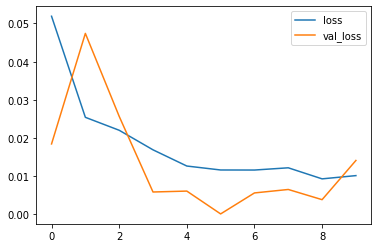

<Figure size 432x288 with 0 Axes>

In [14]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
plt.show()
plt.savefig(stock_ticker+'_'+stock_parameter+'loss_chart.png')

In [15]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [16]:
true_predictions =scaler.inverse_transform(test_predictions)


In [17]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

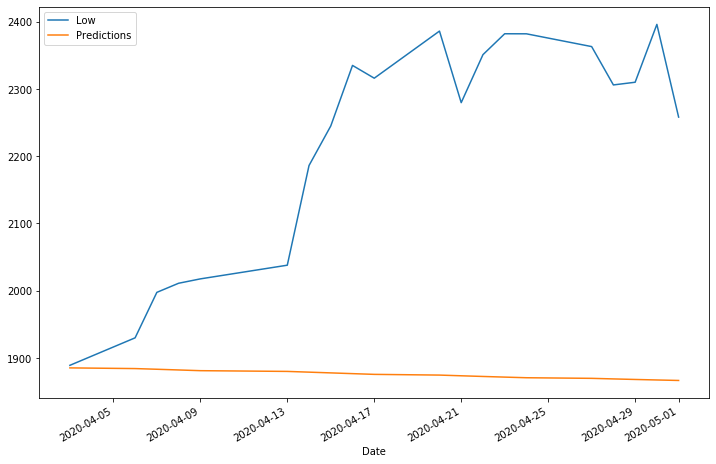

<Figure size 432x288 with 0 Axes>

In [18]:
ax=predictions.plot(figsize=(12,8))
plt.show()
plt.savefig(stock_ticker+'_'+stock_parameter+'predictions_chart.png')

In [19]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'prediction'+'.h5')

Using TensorFlow backend.


# Forecasting

In [20]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(stock[stock_parameter].to_frame())

In [21]:
length=19
generator=TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [31]:
forecast_model= Sequential()
# forecast_model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
# forecast_model.add(Dropout(0.5))
# forecast_model.add(Dense(50, activation='relu'))
# forecast_model.add(Dropout(0.5))
# forecast_model.add(Dense(15, activation='relu'))
# forecast_model.add(Dropout(0.5))
# forecast_model.add(Dense(1, activation='relu'))
# forecast_model.compile(optimizer='adam', loss='mse')

forecast_model.add(LSTM(10, activation='relu', input_shape=(length, n_features)))
forecast_model.add(Dropout(0.15))
# forecast_model.add(Dense(30, activation='relu'))
# forecast_model.add(Dropout(0.25))
# forecast_model.add(Dense(10, activation='relu'))
# forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(1, activation='relu'))
forecast_model.compile(optimizer='adam', loss='mse')

forecast_model.fit_generator(generator, epochs=epoch_number_forecast)

  ...
    to  
  ['...']
Train for 463 steps
Epoch 1/200
463/463 [==============================] - 6s 14ms/step - loss: 0.0236
Epoch 2/200
463/463 [==============================] - 4s 10ms/step - loss: 0.0132
Epoch 3/200
463/463 [==============================] - 4s 10ms/step - loss: 0.0093
Epoch 4/200
463/463 [==============================] - 4s 9ms/step - loss: 0.0077
Epoch 5/200
463/463 [==============================] - 4s 9ms/step - loss: 0.0071
Epoch 6/200
463/463 [==============================] - 5s 10ms/step - loss: 0.0063
Epoch 7/200
463/463 [==============================] - 4s 9ms/step - loss: 0.0075
Epoch 8/200
463/463 [==============================] - 4s 9ms/step - loss: 0.0063
Epoch 9/200
463/463 [==============================] - 4s 9ms/step - loss: 0.0052
Epoch 10/200
463/463 [==============================] - 4s 9ms/step - loss: 0.0058
Epoch 11/200
463/463 [==============================] - 5s 10ms/step - loss: 0.0054
Epoch 12/200
463/463 [========================

In [32]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'forecast'+'.h5')

In [33]:
forecast =[]

periods=19

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [34]:
forecast = scaler.inverse_transform(forecast)

In [35]:
forecast

array([[2082.24262825],
       [2078.56634954],
       [2073.64635111],
       [2068.55723124],
       [2063.33778298],
       [2058.0445159 ],
       [2052.6827246 ],
       [2047.29558036],
       [2041.91586891],
       [2036.5742887 ],
       [2031.24156674],
       [2025.98301996],
       [2020.75410253],
       [2015.58149103],
       [2010.48666929],
       [2005.45578991],
       [2000.51527494],
       [1995.65967706],
       [1990.87133067]])

In [36]:
from datetime import date
forecast_index = pd.date_range(start=date.today(), periods = periods, freq="D")

In [37]:
forecast_df = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

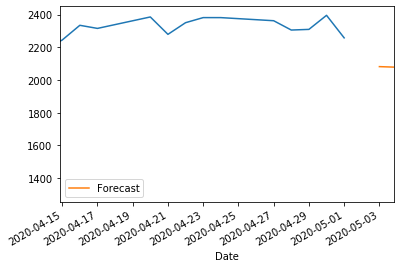

In [38]:
ax=stock[stock_parameter].plot()
forecast_df.plot(ax=ax)
plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')


In [39]:
forecast_df.to_csv('forecast_'+stock_ticker+'_'+stock_parameter+'.csv')